In [1]:
import warnings
warnings.filterwarnings('ignore')
import random

from src.data import load_victim_data
from src.utils import build_config, update_config, get_device, set_seeds, show_multiple
from src.models.modelzoo import get_model
from src.attacks import get_attack

# Set the scenario
Feel free to adjust the parameters and explore some different scenarios.

Note: If DEBUG_RUN is set to True, the attacks will only do a maximum of 150 attack iterations to save time. The differences between the attacks can still be observed for some cases.

In [2]:
#DATASET = 'MNIST'
DATASET = 'CIFAR10'
#DATASET = 'MedMNISTBlood'
#DATASET = 'MedMNISTDerma'
#DATASET = 'MedMNISTPneumonia'
#DATASET = 'MedMNISTRetina'

MODEL = 'CNN' 
#MODEL = 'ViT' 
#MODEL = 'ResNet18'


#ATTACK = 'iDLG'
ATTACK = 'IG'
#ATTACK = 'CPL'

VICTIM_BATCHSIZE = 1
NUM_BATCHES = 3
NUM_SAMPLES = VICTIM_BATCHSIZE * NUM_BATCHES # should not exceed victim dataset size of 128

SEED = 42
DEBUG_RUN = True
DEVICE = get_device()

GPU : Tesla V100-SXM2-16GB


### Load and set configurations for training scenario, dataset and attack

In [3]:
config = build_config('configs/main_config.yaml')
training_config = build_config('./configs/fedavg.yaml')
config = update_config(config, training_config)
attack_config = build_config(f'./configs/attacks/{ATTACK}.yaml')
config = update_config(config, attack_config)
data_config = build_config(f'./configs/data/{DATASET}.yaml')
config = update_config(config, data_config)

config.seed = SEED
config.debug = DEBUG_RUN
config.attack.num_samples = NUM_SAMPLES
config.attack.num_batches = NUM_BATCHES
config.attack.victim_batchsize = VICTIM_BATCHSIZE
config.device = DEVICE
config.experiment_name = f'{DATASET}_{MODEL}_{ATTACK}_seed{SEED}'


### Load victim dataset and select a few random images for demonstration

Loaded victim data from ./data/victim_datasets/CIFAR10_128.tdump!
Loaded victim dataset CIFAR10 with batchsize 1. Data samples are of shape torch.Size([3, 32, 32]).
Seed was set to 42


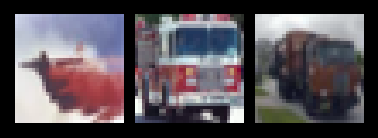

In [4]:
victim_inputs, victim_targets, data_shape = load_victim_data(f'./data/victim_datasets/{DATASET}_128.tdump', VICTIM_BATCHSIZE)
print(f'Loaded victim dataset {DATASET} with batchsize {VICTIM_BATCHSIZE}. Data samples are of shape {data_shape}.')
#show_multiple(victim_inputs, 16, 8, img_scale=DATASET) # SHOW WHOLE VICTIM DATASET


set_seeds(SEED)
assert NUM_SAMPLES <= 128
selection = random.sample(range(len(victim_targets)), NUM_BATCHES)

selected_vicitm_inputs = [victim_inputs[i] for i in selection]
selected_vicitm_targets = [victim_targets[i] for i in selection]

original_imgs = []
for img_batch in selected_vicitm_inputs:
    original_imgs.extend(img_batch.split(1))
show_multiple(original_imgs, NUM_SAMPLES, 1, img_scale=DATASET, figsize=(NUM_SAMPLES, 1))

# Attack Demo

##  Baseline attack and the baseline model

### Get the model (baseline)

In [5]:
model_config = build_config(f'./configs/models/{MODEL}.yaml')
config = update_config(config, model_config)

model = get_model(config.model.name, config)
model = model.to(config.device)
model

Loaded model with CNN architecture, input shape [3, 32, 32], 10 classes.
Setting the models checkpoint path to ./checkpoints/CIFAR10_CNN_IG_seed42.ckpt


CNN(
  (conv_layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
    (1): CNNBlock(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
    (2): CNNBlock(
      (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
  )
  (mlp_layers): ModuleList(
    (0): MLPBlock(
      (linear): Linear(in_features=64, out_features=10, bias=True)
      (regularization_layers): ModuleList()
    )
  )
)

### Attack

In [6]:
if DEBUG_RUN:
    config.attack.max_iterations = 150
attacker = get_attack(config.attack.name, config.data.dataset, model, selected_vicitm_inputs, selected_vicitm_targets, config)
print('________________________________________________________')
reconstructions, results = attacker.attack()

Victim batchsize: 1
Max iterations: 150


________________________________________________________
Attacking victim batch 0!
Using Adam optimizer with learning rate 1
Reconstruction was stopped after 150 iterations for batch 0 trial 0
Execution of attack_batch took 1120.98 ms.
The reconstruction reached a mean MSE score of 0.029038.
The reconstruction reached a mean PSNR score of 15.37026.
The reconstruction reached a mean SSIM score of 0.52578.
The reconstruction reached a mean LPIPS score of 0.43631.
The reconstruction reached a best reconstruction loss of 0.1078432 after 72 iterations.
Attacking victim batch 1!
Using Adam optimizer with learning rate 1
Reconstruction was stopped after 150 iterations for batch 1 trial 0
Execution of attack_batch took 1303.29 ms.
The reconstruction reached a mean MSE score of 0.038611.
The reconstruction reached a mean PSNR score of 14.13295.
The reconstruction reached a mean SSIM score of 0.52349.
The reconstruction reached a mean LPIPS score of 0.44611.
The reconstruction reached a best rec

________________________________________________________
Originals:


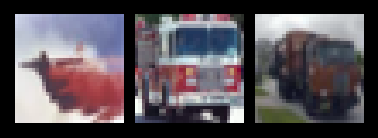

Reconstructions:


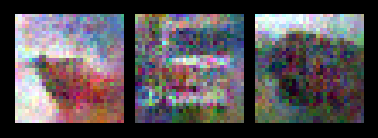

In [7]:
reconstructed_images = []
for b in range(NUM_BATCHES):
    reconstructed_images.extend(reconstructions[b]['Reconstructions'].split(1))
print('________________________________________________________')
print('Originals:')
show_multiple(original_imgs, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))
print('Reconstructions:')
show_multiple(reconstructed_images, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))

## Baseline attack extended with our proposed "Ignore" attack and the CVB protected model

### Get the model (CVB protected)

In [8]:
model_config = build_config(f'./configs/models/{MODEL}CVB.yaml')
config = update_config(config, model_config)

model = get_model(config.model.name, config)
model = model.to(config.device)
model

Loaded model with VBCNN architecture, input shape [3, 32, 32], 10 classes.
Setting the models checkpoint path to ./checkpoints/CIFAR10_CNN_IG_seed42.ckpt


VBCNN(
  (conv_layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
    (1): CNNBlock(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
    (2): CNNBlock(
      (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
  )
  (mlp_layers): ModuleList(
    (0): MLPBlock(
      (linear): Linear(in_features=64, out_features=10, bias=True)
      (regularization_layers): ModuleList()
    )
  )
  (VB_list): ModuleList(
    (0): FullyConvolutionalVariationalBottleneck(
      (encoder): ConvolutionalVariationalEncoder(
        (mu_encoder): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
        (std_encoder): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
      )
      (decoder): ConvolutionalVariationalDeco

### Attack

In [9]:
attacker.max_iterations
attacker = get_attack(config.attack.name, config.data.dataset, model, selected_vicitm_inputs, selected_vicitm_targets, config)
print('________________________________________________________')
reconstructions, results = attacker.attack()

Victim batchsize: 1
Max iterations: 150


________________________________________________________
Attacking victim batch 0!
Using Adam optimizer with learning rate 1
Reconstruction was stopped after 150 iterations for batch 0 trial 0
Execution of attack_batch took 1635.18 ms.
The reconstruction reached a mean MSE score of 0.095376.
The reconstruction reached a mean PSNR score of 10.20561.
The reconstruction reached a mean SSIM score of 0.24057.
The reconstruction reached a mean LPIPS score of 0.56435.
The reconstruction reached a best reconstruction loss of 0.2593712 after 112 iterations.
Attacking victim batch 1!
Using Adam optimizer with learning rate 1
Reconstruction was stopped after 150 iterations for batch 1 trial 0
Execution of attack_batch took 1722.83 ms.
The reconstruction reached a mean MSE score of 0.118985.
The reconstruction reached a mean PSNR score of 9.24506.
The reconstruction reached a mean SSIM score of 0.28240.
The reconstruction reached a mean LPIPS score of 0.59730.
The reconstruction reached a best rec

________________________________________________________
Originals:


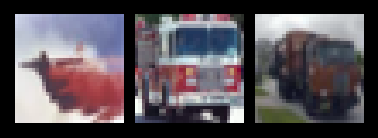

Reconstructions:


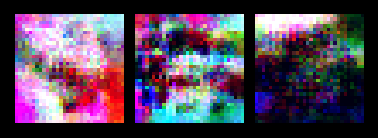

In [10]:
reconstructed_images = []
for b in range(NUM_BATCHES):
    reconstructed_images.extend(reconstructions[b]['Reconstructions'].split(1))
print('________________________________________________________')
print('Originals:')
show_multiple(original_imgs, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))
print('Reconstructions:')
show_multiple(reconstructed_images, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))

## Baseline attack (without our "Ignore" mechanism) and CVB protected model

### Get the model (CVB protected)

In [11]:
model_config = build_config(f'./configs/models/{MODEL}CVB.yaml')
config = update_config(config, model_config)

model = get_model(config.model.name, config)
model = model.to(config.device)
model

Loaded model with VBCNN architecture, input shape [3, 32, 32], 10 classes.
Setting the models checkpoint path to ./checkpoints/CIFAR10_CNN_IG_seed42.ckpt


VBCNN(
  (conv_layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
    (1): CNNBlock(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
    (2): CNNBlock(
      (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=valid)
      (activation_function): ReLU()
    )
  )
  (mlp_layers): ModuleList(
    (0): MLPBlock(
      (linear): Linear(in_features=64, out_features=10, bias=True)
      (regularization_layers): ModuleList()
    )
  )
  (VB_list): ModuleList(
    (0): FullyConvolutionalVariationalBottleneck(
      (encoder): ConvolutionalVariationalEncoder(
        (mu_encoder): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
        (std_encoder): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
      )
      (decoder): ConvolutionalVariationalDeco

### Attack

In [12]:
if DEBUG_RUN:
    attacker.max_iterations = 150
config.attack.ignore_gradient_layers = []
attacker = get_attack(config.attack.name, config.data.dataset, model, selected_vicitm_inputs, selected_vicitm_targets, config)
print('________________________________________________________')
reconstructions, results = attacker.attack()

Victim batchsize: 1
Max iterations: 150


________________________________________________________
Attacking victim batch 0!
Using Adam optimizer with learning rate 1
Reconstruction was stopped after 150 iterations for batch 0 trial 0
Execution of attack_batch took 2043.46 ms.
The reconstruction reached a mean MSE score of 0.145067.
The reconstruction reached a mean PSNR score of 8.38432.
The reconstruction reached a mean SSIM score of 0.06925.
The reconstruction reached a mean LPIPS score of 0.54012.
The reconstruction reached a best reconstruction loss of 0.5998054 after 93 iterations.
Attacking victim batch 1!
Using Adam optimizer with learning rate 1
Reconstruction was stopped after 150 iterations for batch 1 trial 0
Execution of attack_batch took 2039.58 ms.
The reconstruction reached a mean MSE score of 0.139719.
The reconstruction reached a mean PSNR score of 8.54743.
The reconstruction reached a mean SSIM score of 0.11671.
The reconstruction reached a mean LPIPS score of 0.63534.
The reconstruction reached a best recon

________________________________________________________
Originals:


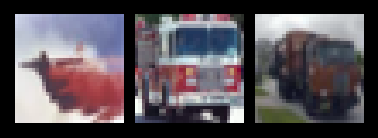

Reconstructions:


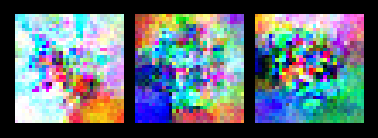

In [13]:
reconstructed_images = []
for b in range(NUM_BATCHES):
    reconstructed_images.extend(reconstructions[b]['Reconstructions'].split(1))
print('________________________________________________________')
print('Originals:')
show_multiple(original_imgs, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))
print('Reconstructions:')
show_multiple(reconstructed_images, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))